 # <center> UNICEF EDA </center>

Вас пригласили поучаствовать в одном из проектов UNICEF — международного подразделения ООН, чья миссия состоит в повышении уровня благополучия детей по всему миру. 

Суть проекта — отследить влияние условий жизни учащихся в возрасте от 15 до 22 лет на их успеваемость по математике, чтобы на ранней стадии выявлять студентов, находящихся в группе риска.

Для этого нужно построить модель, которая предсказывала бы результаты госэкзамена по математике для каждого ученика школы.

<img src="https://raw.githubusercontent.com/Deus99/skillfactory_rds/master/module_2/logo_eda.png"> 

# Библиотеки используемые в анализе

In [225]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.stats import ttest_ind
from scipy.stats import pearsonr
import warnings
from sklearn.impute import KNNImputer

In [226]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
pd.set_option('precision', 4)
%matplotlib inline

*Проведите первичную обработку данных. 
Так как данных много, стоит написать функции, которые можно применять к столбцам определённого типа.
Посмотрите на распределение признака для числовых переменных, устраните выбросы.
Оцените количество уникальных значений для номинативных переменных.
По необходимости преобразуйте данные
Проведите корреляционный анализ количественных переменных
Отберите не коррелирующие переменные.
Проанализируйте номинативные переменные и устраните те, которые не влияют на предсказываемую величину (в нашем случае — на переменную score).
Не забудьте сформулировать выводы относительно качества данных и тех переменных, которые вы будете использовать в дальнейшем построении модели.*

# Загрузка данных

In [227]:
math = pd.read_csv("stud_math.xls")
math.head(3)

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
0,GP,F,18,U,NaN,A,4.0,4.0,at_home,teacher,course,mother,2.0,2.0,0.0,yes,no,no,no,yes,-6.0,yes,NaN,no,4.0,3.0,4.0,3.0,6.0,30.0
1,GP,F,17,U,GT3,NaN,1.0,1.0,at_home,other,course,father,1.0,2.0,0.0,no,yes,no,no,no,-6.0,yes,yes,no,5.0,3.0,3.0,3.0,4.0,30.0
2,GP,F,15,U,LE3,T,1.0,1.0,at_home,other,other,mother,1.0,2.0,3.0,yes,no,NaN,no,yes,-6.0,yes,yes,NaN,4.0,3.0,2.0,3.0,10.0,50.0


# Используемые функции
### Статистические функции

In [228]:
def iqr_test(column, lim_a, lim_b):
    """
    Функция определения медианы, квантилей 25%/75% и 
    границы выбросов для данного сталбцы 
    lim_a lim_b - пределы для построенния гистограммы
    """
    median = math[column].median()
    IQR = math[column].quantile(0.75) - math[column].quantile(0.25)
    perc25 = math[column].quantile(0.25)
    perc75 = math[column].quantile(0.75)
    print('25-й перцентиль: {},'.format(perc25), 
          '75-й перцентиль: {},'.format(perc75), 
          "IQR: {}, ".format(IQR),
          "Границы выбросов: [{f}, {l}]."
          .format(f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR))
    math[column].loc[math[column].between(perc25 - 1.5*IQR, perc75 + 1.5*IQR)]\
    .hist(bins=8, range=(lim_a, lim_b), label='IQR')

        
def get_boxplot(column):
    """функция генерации боксплота (score) для списка колонок"""
    fig, ax = plt.subplots(figsize=(8, 4))
    sns.boxplot(x=column, y='score', 
                data=math, ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()


def get_boxplot2(column):
    """функция генерации боксплота (score) для списка колонок"""
    math2 = math.copy()
    math2[column] = math2[column].dropna()
    fig, ax = plt.subplots(figsize=(8, 4))
    sns.boxplot(x=column, y='score', 
                data=math2, ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()

        
def get_stat_dif(column):
    """функция проверки статистических различия для состава колонок"""
    math2 = math.copy()
    math2[column] = math2[column].dropna()
    cols = math2.loc[:, column].value_counts().index[:5]
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(math2.loc[math2.loc[:, column] == comb[0], 'score'], 
                     math2.loc[math2.loc[:, column] == comb[1], 'score']).pvalue\
            <= 0.05/len(combinations_all): # Учли поправку Бонферони
            print('Найдены статистически значимые различия для колонки', column)
            break  

### Функции для заполнения пропусков в данных

In [460]:
score_F = round(math[math.score.between(25, 39)].score.mean(), 0)

def score_corr(row):
    """
    Функция коррекции оценки (Score) для двоечников (0 баллов) 
    в зависимости от пола и возраста заполняем через словарь score0
    для пустых значений словаря -  score_F (примерно 30)
    """
    if row['score'] == 0:
        try:
            row['score'] = round(scores0[row['sex']][row['age']], 0)
        except:
            row['score'] = score_F
    return row


def yesno_fill(yp):
    """функция случайного заполнения yes/no для бинарных переменных
    использует входящую пропорцию для ответа 'yes' - yp"""
    x = np.random.choice(['yes', 'no'], p=[yp, 1-yp])
    return x
    

### Создание словарей для заполнения

In [230]:
#Заполнять пропущенные значения Medu/Fedu и Mjob/Fjob будем через словарь;
#Значения где .edu и .job одновременно = Nan заполним модой 

m_edu = {} # словарь работа -- образование для мам Medu - Mjob
for job in math[~math.Mjob.isnull()].Mjob.unique():
    edu = math[math.Mjob == job].mode()['Medu'][0]
    m_edu[job] = edu

f_edu = {} # словарь работа -- образование для отцов Fedu - Fjob
for job in math[~math.Fjob.isnull()].Fjob.unique():
    edu = math[math.Fjob == job].mode()['Fedu'][0]
    f_edu[job] = edu

f_job = {} # словаь образование -- работа для отцов Fjob - Fedu
for edu in math[~math.Fedu.isnull()].Fedu.unique():
    job = math[math.Fedu == edu].mode()['Fjob'][0]
    f_job[edu] = job

m_job = {} # словаь образование -- работа для мам Mjob - Medu
for edu in math[~math.Medu.isnull()].Medu.unique():
    job = math[math.Medu == edu].mode()['Mjob'][0]
    m_job[edu] = job

### Функции для визуализации 

# Разведывательный анализ данных

## Пропущенные значения
Посмотрим пропущенные значения для всех колонок

In [231]:
display(math.isnull().sum())

school                  0
sex                     0
age                     0
address                17
famsize                27
Pstatus                45
Medu                    3
Fedu                   24
Mjob                   19
Fjob                   36
reason                 17
guardian               31
traveltime             28
studytime               7
failures               22
schoolsup               9
famsup                 39
paid                   40
activities             14
nursery                16
studytime, granular     7
higher                 20
internet               34
romantic               31
famrel                 27
freetime               11
goout                   8
health                 15
absences               12
score                   6
dtype: int64

In [232]:
#Суммарно данных потеряно
lost = math.isnull().sum().sum()*100 / (len(math)*30)
print ('%.2f' % lost + '%' +' данных потеряно')

4.77% данных потеряно


Потеряно около 5% от общего количества данных. В целевой переменной **score** 6 значений пропущено. 
Больше всего пропусков для значений связанных с дополнительной поддержкой (**schoolsup, paid**), семеным статусов (**famsize, Pstatus, guardian**) и дополнительными параметрами как наличие интернета и романтических отношений (**internet, romantic**)

Только 3 столбца (**school, age, sex**) без отсутвующих данных

Позже попробуем заполнить некоторые пробелы или удалить столбцы, которые не влияют на общую оценку

## Оценка уникальных значений и типов переменных в датафрейме

In [233]:
math.describe(include = 'all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
school,395,2,GP,349,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sex,395,2,F,208,NaN,NaN,NaN,NaN,NaN,NaN,NaN
age,395,NaN,NaN,NaN,16.7,1.276,15,16,17,18,22
address,378,2,U,295,NaN,NaN,NaN,NaN,NaN,NaN,NaN
famsize,368,2,GT3,261,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Pstatus,350,2,T,314,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Medu,392,NaN,NaN,NaN,2.75,1.098,0,2,3,4,4
Fedu,371,NaN,NaN,NaN,2.615,2.229,0,2,2,3,40
Mjob,376,5,other,133,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Fjob,359,5,other,197,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Три стобца являются *количественными* переменными:  
 **age** - возраст от 15 до 22 лет.  
 **absences** - пропуски занятий, от 0 до 385, со средним значением около 7.  
 **score** -  итоговая оценка, от 0 до 100.

*Категориальные* (оценочные), 9 столбцов:   
**Medu, Fedu** - образование матери и отца ( 0 - нет, 1 - 4 класса, 2 - 5-9 классы, 3 - среднее специальное или 11 классов, 4 - высшее)  
**traveltime** - время в пути до школы (1 - <15 мин., 2 - 15-30 мин., 3 - 30-60 мин., 4 - >60 мин.)  
**studytime (..granular)** - в время на учёбу помимо школы в неделю (1 - <2 часов, 2 - 2-5 часов, 3 - 5-10 часов, 4 - >10 часов)  
**failures** - количество внеучебных неудач (n, если 1<=n<3, иначе 0)  
**famrel** - семейные отношения (от 1 - очень плохо до 5 - очень хорошо)   
**freetime** - свободное время после школы (от 1 - очень мало до 5 - очень мого)  
**goout** - проведение времени с друзьями (от 1 - очень мало до 5 - очень много)  
**health** - текущее состояние здоровья (от 1 - очень плохо до 5 - очень хорошо)

*Категориальные* (номинативные), 4 столбца:   
**Mjob, Fjob** работа матери и отца ('teacher' - учитель, 'health' - сфера здравоохранения, 'services' - гос служба, 'at_home' - не работает, 'other' - другое)   
**reason** - причина выбора школы (**'home'** - близость к дому, **'reputation'** - репутация школы, **'course'** - образовательная программа, **'other'** - другое)  
**guardian** - опекун (**'mother'** - мать, **'father'** - отец, **'other'** - другое)

*Категориальные* (бинарные), 13 столбцов:  
**school** - аббревиатура школы, в которой учится ученик (**GP** - General Purpose? и **MS** - Middle School?)  
**sex**  - пол ученика (**'F'** - женский, **'M'** - мужской)  
**address** - тип адреса ученика (**'U'** Urban - городской, **'R'** Recreation - за городом)   
**famsize** - размер семьи(**'LE3'** <= 3, **'GT3'** >3)   
**Pstatus** - статус совместного жилья родителей (**'T'** - живут вместе **'A'** - раздельно)  
Столбцы содержащие значение **yes/no**    
**schoolsup** - дополнительная образовательная поддержка (**yes или no**)   
**famsup** - семейная образовательная поддержка (**yes или no**)  
**paid** - дополнительные платные занятия по математике (**yes или no**)  
**activities** - дополнительные внеучебные занятия (**yes или no**)  
**nursery** - посещал детский сад (**yes или no**)  
**higher** - хочет получить высшее образование (**yes или no**)  
**internet** - наличие интернета дома (**yes или no**)  
**romantic** - в романтических отношениях (**yes или no**)  

## Исправление ошибок в данных.
При осмотре статистической таблицы и условий видны следующие ошибки.
- **Fedu** - значение *40*, скорее всего опечатка, исправим на 4.0  
- **famrel** - значение *-1*  - скорее всего опечатка, исправим на 1.0  
- столбец **studytime, granular** без описания, сравним со столбцом **studytime**  

### Studytime, granular
Про данный столбец нет описания, но возможно он относиться к столбцу **studytime**. Посмотрим пропущенные значения и зависимость между столбцами. В этих столбцах пропущенно по 7 значений. 

In [234]:
math[math.studytime.isna()]

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
17,GP,F,16,U,GT3,T,3.0,3.0,other,NaN,reputation,mother,3.0,NaN,0.0,yes,NaN,no,yes,yes,NaN,yes,no,no,5.0,3.0,2.0,4.0,4.0,50.0
91,GP,F,15,U,GT3,T,4.0,3.0,services,other,reputation,mother,1.0,NaN,NaN,no,no,yes,yes,yes,NaN,yes,yes,no,4.0,5.0,5.0,1.0,4.0,90.0
112,GP,F,16,U,GT3,NaN,2.0,2.0,at_home,other,NaN,mother,NaN,NaN,1.0,yes,no,no,yes,yes,NaN,yes,yes,NaN,3.0,1.0,2.0,5.0,6.0,65.0
129,GP,M,16,R,NaN,T,4.0,4.0,teacher,teacher,course,mother,1.0,NaN,0.0,no,no,yes,yes,yes,NaN,yes,yes,no,3.0,5.0,5.0,4.0,NaN,90.0
227,GP,M,17,U,LE3,NaN,2.0,3.0,services,services,reputation,father,1.0,NaN,0.0,no,yes,yes,no,no,NaN,NaN,yes,no,5.0,3.0,3.0,3.0,NaN,60.0
266,GP,M,17,U,GT3,NaN,3.0,1.0,services,NaN,other,mother,1.0,NaN,0.0,no,no,yes,yes,yes,NaN,yes,yes,NaN,5.0,4.0,4.0,NaN,2.0,50.0
314,GP,F,19,U,GT3,T,1.0,1.0,at_home,health,home,other,1.0,NaN,2.0,no,no,no,no,no,NaN,yes,yes,yes,4.0,NaN,2.0,3.0,14.0,65.0


Пропущенные значения также совпадают, посмотрим на графике, как соотносятся данные.

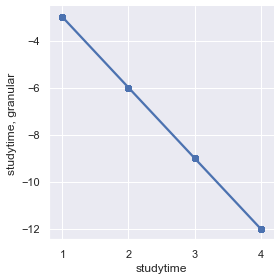

In [235]:
sns.lmplot(x='studytime', y='studytime, granular', height=4, data=math)
plt.show()

По графтку видна линейная зависимость между столбцами. Возможно, это немного другая оценка времени **studytime**. Проверим коэффициентом корреляции.

In [236]:
math[['studytime', 'studytime, granular']].corr()

,studytime,"studytime, granular"
studytime,1.0,-1.0
"studytime, granular",-1.0,1.0


Данные в столбце **studytime, granular** копируют столбец **studytime** с коэффициентом -3. Столбец **studytime, granular** нам не нужен - удаляем.  
Исправляем значения в столбцах **Fedu** и **famrel** 

In [237]:
math = math.drop('studytime, granular', axis=1)
math.Fedu = math.Fedu.apply(lambda x: 4.0 if x==40.0 else x)
math.famrel = math.famrel.apply(lambda x: 1 if x ==-1 else x)

### Score - Финальная оценка по экзамену

Кратко распишем традиционную систему оценок для 100-бальной системы
* 80-100 Отлично/Зачтено  "A+" или "A"
* 60-79 Хорошо/Зачтено "B" или "C"
* 40-59 Удовлетворительно/Зачтено "D" или "E"
* 0-39 Неудовлетворительно/ Не Зачтено "Fx" или "F"

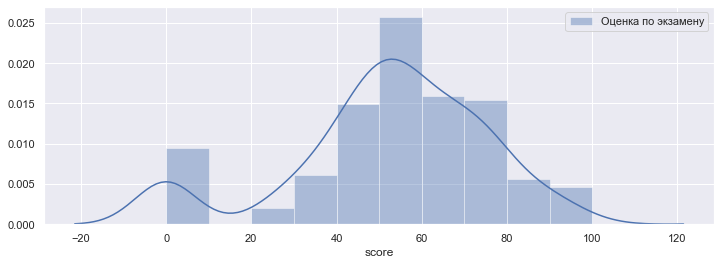

In [238]:
sns.set()
fig, ax = plt.subplots(figsize=[12,4])
sns.distplot(math['score'], bins = 10, label = "Оценка по экзамену" )
ax.legend(loc=1)

plt.show()

Из гистограммы и графика распределения видно, что много значений с нулевой оценкой (также есть 6 значений **NaN**). Такое большое количество оценок связано с больших количеством оценок "F" или "Неуд", когда баллов было набрано менее 39. Именно в этих случаях часто просто ставят "F" вместе с баллами, что потом может быть занесено как 0 баллов. Поэтому заменим данные значения по среднему значению в промежутке от 0-39.

Значения **Nan** для столбца **score** заменим средним. 

In [239]:
# Заполняем нулевые значения через функцию
math = math.apply(score_corr, axis=1)
math.score = math.score.fillna(math.score.mean())

#### Гистограмма распределения оценки после коррекции.

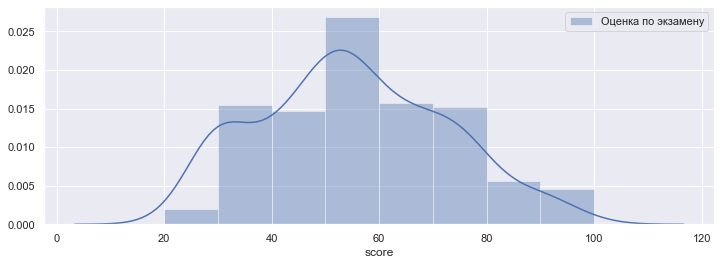

In [240]:
sns.set()
fig, ax = plt.subplots(figsize=[12,4])
sns.distplot(math['score'], bins = 8, label = "Оценка по экзамену" )
ax.legend(loc=1)

plt.show()

Проверим распределение финальной оценки на выбросы

25-й перцентиль: 40.0, 75-й перцентиль: 70.0, IQR: 30.0,  Границы выбросов: [-5.0, 115.0].


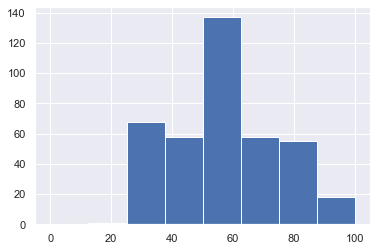

In [241]:
iqr_test('score', 0, 100)

Как видно из гистограммы - выбросов нет. 

### Школы, возраст и пол учеников (school, age, sex)
В датасете присутвует всего 2 вида школ **GP** (General Practice? ) и **MS** (Middle School ?)  
Что бы проверить что это за школы проведем исследование по возрасту (**age**) и полу (**sex**)

In [242]:
display(math.school.unique())
display(math.sex.unique())

array(['GP', 'MS'], dtype=object)

array(['F', 'M'], dtype=object)

In [243]:
pd.pivot_table(math, index = "school", columns = 'age', values = 'sex', aggfunc = 'count')

age,15,16,17,18,19,20,21,22
school,,,,,,,,
GP,82.0,104.0,86.0,57.0,18.0,1.0,NaN,1.0
MS,NaN,NaN,12.0,25.0,6.0,2.0,1.0,NaN


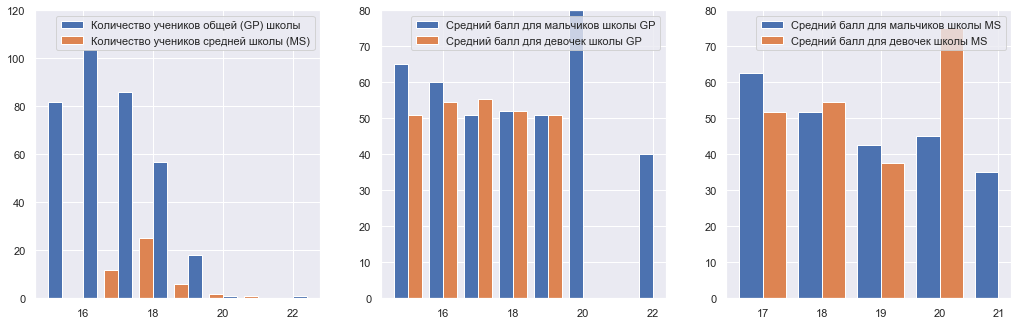

In [244]:
school_age = pd.pivot_table(math, index = 'age', columns = 'school', values = 'sex', aggfunc=('count')).reset_index()
GP_sex = pd.pivot_table(math.query('school == "GP"'), index = 'age', columns = 'sex', values = 'score', aggfunc = 'mean').reset_index()
MS_sex = pd.pivot_table(math.query('school == "MS"'), index = 'age', columns = 'sex', values = 'score', aggfunc = 'mean').reset_index()

fig, axes = plt.subplots (0, 1, figsize = (12, 4) )
axes = fig.add_axes([0, 0, 0.33, 1])
axes.set_ylim(0, 120)
axes.bar(x = school_age['age'], height = school_age['GP'],
               width = 0.4, align = 'edge', label = 'Количество учеников общей (GP) школы')
axes.bar(x = school_age['age'], height = school_age['MS'],
               width = -0.4, align = 'edge', label = 'Количество учеников средней школы (MS)')
axes.legend(loc=1)

axes = fig.add_axes([0.4, 0, 0.33, 1])
axes.set_ylim(0, 80)
axes.bar(x = GP_sex['age'], height = GP_sex['M'],
               width = -0.4, align = 'edge', label = 'Средний балл для мальчиков школы GP')
axes.bar(x = GP_sex['age'], height = GP_sex['F'],
               width = 0.4, align = 'edge', label = 'Средний балл для девочек школы GP')
axes.legend(loc=1)

axes = fig.add_axes([0.8, 0, 0.33, 1])
axes.set_ylim(0, 80)
axes.bar(x = MS_sex['age'], height = MS_sex['M'],
               width = -0.4, align = 'edge', label = 'Средний балл для мальчиков школы MS')
axes.bar(x = MS_sex['age'], height = MS_sex['F'],
               width = 0.4, align = 'edge', label = 'Средний балл для девочек школы MS')


axes.legend(loc=1)

plt.show()

По диаграмме видно, что школы явно ранжированны по возрасту. GP - основной возраст 15 - 19 лет. MS от 17 до 22. Также видно, что есть ученик школы GP возрастом 22 года и ученики школы MS возрастом 21 год.

25-й перцентиль: 16.0, 75-й перцентиль: 18.0, IQR: 2.0,  Границы выбросов: [13.0, 21.0].


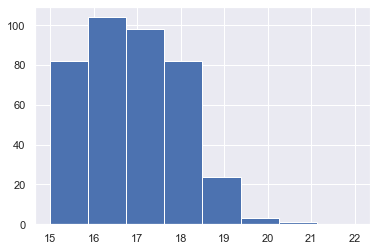

In [245]:
iqr_test('age', 15, 22)

Так как мы считаем возраст непрерывной случайной величиной, то возраст 22 - считается выбросом, нужно заменить его или удалить.

*Примечание. С точки зрения логики одно зачение возраста выше чем средний, это просто день рожденья ученика на несколько дней(пару месяцев) раньше чем дата экзамена, такое может произойти во многих случаях (перенос даты ЕГЭ 2020 г из-за COVID-19), поэтому не будем этот возраст выбросом заменим его на 21.*

In [246]:
# заменяем значение 22 на 21.
math.age = math.age.replace(22, 21)

### Absences - пропуски занятий
Если судить по таблице describe, максимальное значение 385. Проверим данные на выбросы.

25-й перцентиль: 0.0, 75-й перцентиль: 8.0, IQR: 8.0,  Границы выбросов: [-12.0, 20.0].


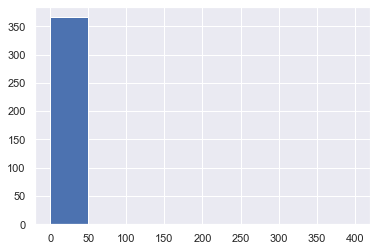

In [247]:
iqr_test('absences', 0, 400)

Выбросы у нас по верхней границе - нужно удалить лишние данные или заменить. Но удалять мы их будем (данных много), только в том случае, если окажется, что данный параметр влияет на итоговые значение. Для этого вначале проверим в корреляционном анализе урезанный датафрейм (без выбросов), и если этот параметр влияет - тогда удалим, иначе заменим на максимальный по границе выбросов (20)

In [248]:
abs25 = math.absences.quantile(0.25)
abs75 = math.absences.quantile(0.75)
IQR = math.absences.quantile(0.75) - math.absences.quantile(0.25)

### Корреляционный анализ

Построим графики корреляции для величин **age, absences, score.** Т.к. пока мы используем разные датафреймы: для **age** полный, а для **absences** сокращенный, то сделаем отдельно корреляционный анализ. 

### Зависимость оценки от возраста (age/score)

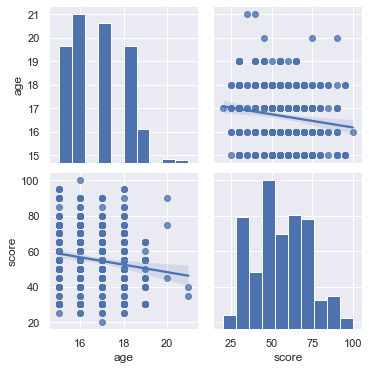

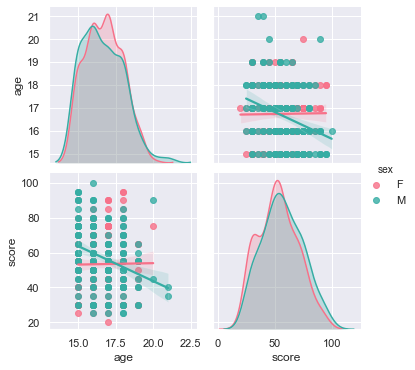

In [249]:
sns.pairplot(math[['age', 'score', 'sex']], kind='reg')
sns.pairplot(math[['age', 'score', 'sex']], kind='reg', hue='sex', palette="husl")
plt.show()

In [250]:
cor_sa, p_sa = pearsonr(math['score'], math['age'])
print ('Коэффициент корреляции для "age"/"score": {:.3f}'.format(cor_sa),
                    'p-value: {:.3f}'.format(p_sa))

Коэффициент корреляции для "age"/"score": -0.152 p-value: 0.002


### Зависимость оценки от пропусков занятий (absences/score)

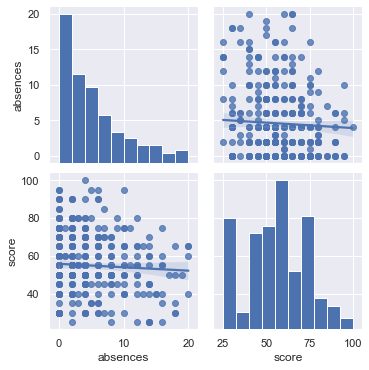

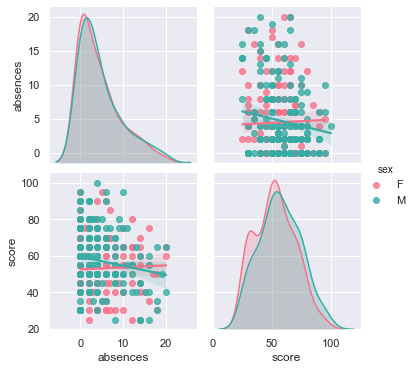

In [251]:
#фильтр для выбросов absences для короткой записи
ma = math.absences.between(abs25 - 1.5*IQR, abs75 + 1.5*IQR)

sns.pairplot(math[ma][['absences', 'score', 'sex']], kind='reg')
sns.pairplot(math[ma][['absences', 'score', 'sex']], kind='reg', hue='sex', palette="husl")
plt.show()

In [252]:
cor_sb, p_sb = pearsonr(math.loc[ma]['score'], math.loc[ma]['absences'])
print ('Коэффициент корреляции для "absences"/"score": {:.3f}'.format(cor_sb),
                    'p-value: {:.3f}'.format(p_sb))

Коэффициент корреляции для "absences"/"score": -0.053 p-value: 0.316


In [253]:
# дополнительня проверка только для мальчиков. 
cor_ma, p_ma = pearsonr(math.query('sex == "M"').loc[ma]['score'], 
                        math.query('sex == "M"').loc[ma]['absences'])

print ('Коэффициент корреляции для "absences"/"score"\
, только мальчик: {:.3f}'.format(cor_ma),
                    '  p-value: {:.3f}'.format(p_ma))

Коэффициент корреляции для "absences"/"score", только мальчик: -0.146   p-value: 0.053


Из графиков, коэффициентов корреляции (и p-value) можно сделать промежуточный вывод для непрерывных переменных 
**age/score** и **absences/score** : 
 
 - Итоговая оценка **score** зависит от возраста **age** и это следует учитывать при последующем анализе. 
 - Итоговая оценка **score** мало зависит от количества пропусков **absences**. Дополнительная проверка только для мальчиков показала, что есть выраженная отрицательная зависимость по коэффициенту корреляции, но она статистически незначительна (p-value > 0.05). 
 
 *Примечание Отсутвие корреляции пропуска занятий и итоговой оценки по математике можно объяснить тем, что в данных у нас пропуски всех занятий за год по всем предметам. Ученик может пропустиь за год (по болезни) 20-50 занятий, но не пропустить ни одного занятия по математике.*
 
 По итогам анализа столбец **absences** можно не заполнять, и мы его удалим.

In [254]:
math = math.drop('absences', axis=1)

### Address - место жительства и Traveltime - время до учебу и обратно
Посмотрим на распределение и зависимости переменных и заполним пропуски.

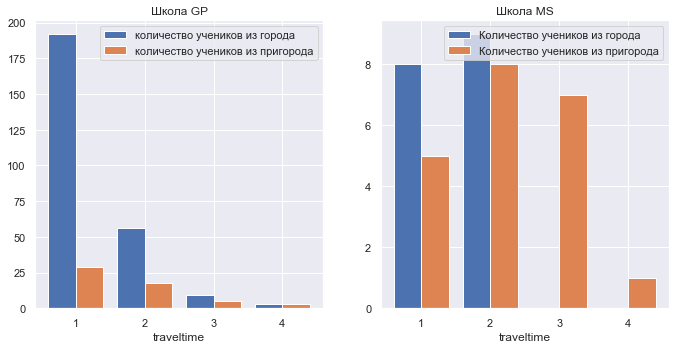

In [255]:
GP_time = pd.pivot_table(math.query('school == "GP"'), index = 'traveltime', columns = 'address', values = 'sex', aggfunc=('count')).reset_index()
MS_time = pd.pivot_table(math.query('school == "MS"'), index = 'traveltime', columns = 'address', values = 'sex', aggfunc=('count')).reset_index()

fig, axes = plt.subplots (0, 2, figsize = (8, 4) )

axes = fig.add_axes([0, 0, 0.5, 1])
axes.bar(x = GP_time['traveltime'], height = GP_time['U'],
               width = -0.4, align = 'edge', label = 'количество учеников из города')
axes.bar(x = GP_time['traveltime'], height = GP_time['R'],
               width = 0.4, align = 'edge', label = 'количество учеников из пригорода')

plt.title('Школа GP')
plt.xlabel('traveltime')
axes.legend(loc=1)

axes = fig.add_axes([0.6, 0, 0.5, 1])
axes.bar(x = MS_time['traveltime'], height = MS_time['U'],
               width = -0.4, align = 'edge', label = 'Количество учеников из города')
axes.bar(x = MS_time['traveltime'], height = MS_time['R'],
               width = 0.4, align = 'edge', label = 'Количество учеников из пригорода')
plt.title('Школа MS')
plt.xlabel('traveltime')

axes.legend(loc=1)

plt.show()

В школу **GP** гораздо больше ходит учеников из города (**U**) и тратит времени минимально (**1.0**) Школа **MS** возможно находится ближе к отдаленным районам (или наоборот в центре города) и ученики из города и пригорода тратят времени примерно одинаково. Для этого рассмотрим дополнительно причину выбора школы **reason**

### Причина выбора школы - reason
Для разного возраста учеников, причины выбора школы может отличаться, также может зависить от местаположения
* **'home'** - близость к дому, 
* **'reputation'** - репутация школы, 
* **'course'** - образовательная программа, 
* **'other'** - другое

Посмотрим как выглядят причины выбора для двух школ GP/MS для разных возрастных групп

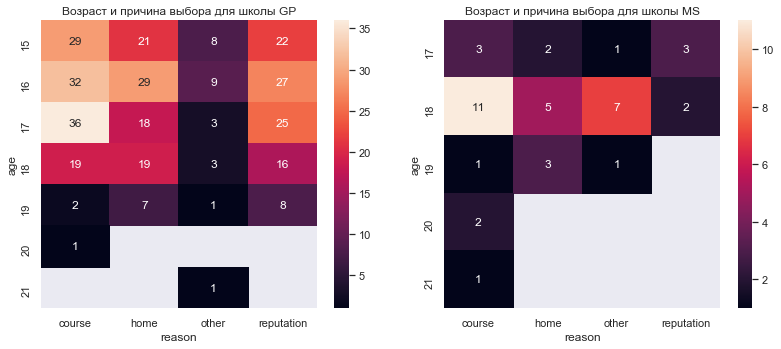

In [256]:
dataGP = math.query('school == "GP"').groupby(['age', 'reason'])['reason'].count().unstack()
dataMS = math.query('school == "MS"').groupby(['age', 'reason'])['reason'].count().unstack()

fig, axes = plt.subplots(0, 2, figsize = (8, 4))

axes = fig.add_axes([0, 0, 0.6, 1])
axes = sns.heatmap(dataGP, annot = True)
plt.title('Возраст и причина выбора для школы GP')

axes = fig.add_axes([0.7, 0, 0.6, 1])
axes = sns.heatmap(dataMS, annot = True)
plt.title('Возраст и причина выбора для школы MS')

plt.show()

Самой распространненой причиной в обеих школах и во всех возрастных группах - является образовательная программа **"course"**. И для школы **GP** близость к дому **'home'**. 

Заполним пробелы в столбцах **address, reason, traveltime** совместно при помощи *KNN*, как вспомогательный столбец будем использовать столбцы школы (**school**) и возраста (**age**). 

In [257]:
train = math[['school','age', 'address', 'reason', 'traveltime']].copy()
imputer = KNNImputer(n_neighbors=3)

In [258]:
train.school = train.school.replace('GP', 1)
train.school = train.school.replace('MS', 2)

train.address = train.address.replace('U', 1)
train.address = train.address.replace('R', 2)

reason_dict = {'course':0, 'reputation':1,'home':2,'other':3}
reason_dict_rev = {0:'course' ,1:'reputation',2:'home',3:'other'}
train.reason = train.reason.replace(reason_dict)

In [259]:
df_fill = imputer.fit_transform(train)

In [395]:
train['address'] = df_fill.T[2]
train['reason'] = df_fill.T[3]
train['traveltime'] = df_fill.T[4]
train = train.round(0)
train.address = train.address.replace(1.0, 'U')
train.address = train.address.replace(2.0, 'R')

#Заполняем пропуски reason, address, traveltime
math.address = train.address
math.traveltime = train.traveltime
math.reason = train.reason.replace(reason_dict_rev)

### Famsize - размер семьи и статус проживания родителей Pstatus
Посмотрим на состав семьи и статус проживания родителей

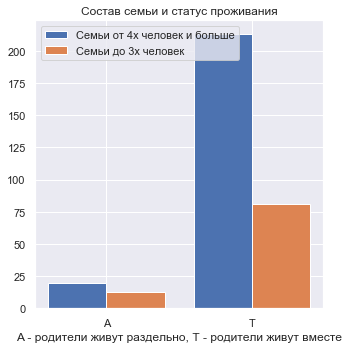

In [261]:
fam_st = pd.pivot_table(math, index = 'Pstatus', columns = 'famsize', values = 'sex', aggfunc = 'count').reset_index()

fig, axes = plt.subplots (0, 2, figsize = (8, 4) )

axes = fig.add_axes([0, 0, 0.5, 1])
axes.bar(x = fam_st['Pstatus'], height = fam_st['GT3'],
               width = -0.4, align = 'edge', label = 'Семьи от 4х человек и больше')
axes.bar(x = fam_st['Pstatus'], height = fam_st['LE3'],
               width = 0.4, align = 'edge', label = 'Семьи до 3х человек')

plt.title('Состав семьи и статус проживания')
plt.xlabel('A - родители живут раздельно, T - родители живут вместе')
axes.legend(loc=2)

plt.show()

In [262]:
display(math['famsize'].value_counts(normalize = True))
display(math['Pstatus'].value_counts(normalize = True))

GT3    0.7092
LE3    0.2908
Name: famsize, dtype: float64

T    0.8971
A    0.1029
Name: Pstatus, dtype: float64

Пропущенных значений для состава семьи (**famsize**) много (27 значений) для статуса проживания (**Pstatus**) еще больше (45 значений). Удалить их мы не можем, потеряем слишком большой процент данных.
Это номинативные(бинарные) переменные, создавать еще одно значения типа  ("Unknown") в данном случае нежелательно. 

Заполним пропуски, самыми популярными значениями:
GTE3  для **famsize**- около 70% 
T для **Pstatus** - около 90%

In [263]:
math.famsize = math.famsize.fillna('GT3')
math.Pstatus = math.Pstatus.fillna('T')

### Уровень образования матери и отцы Medu и Fedu и текущая работа Mjob и Fjob
**Medu / Fedu** (0 - нет, 1 - 4 класса, 2 - 5-9 классы, 3 - среднее специальное или 11 классов, 4 - высшее)


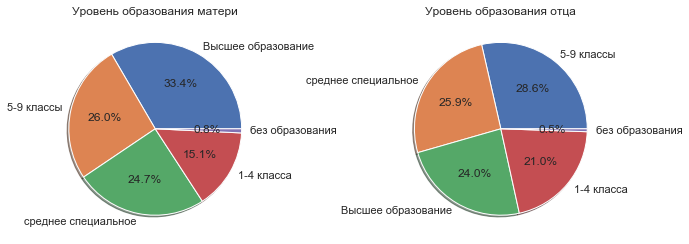

In [264]:
edu_dict = {0.0 : 'без образования', 1.0 : '1-4 класса', 
            2.0 : '5-9 классы', 3.0: 'среднее специальное', 4.0 : 'Высшее образование'}
labels_m = math.Medu.replace(edu_dict).value_counts().reset_index()['index'].to_list()
labels_f = math.Fedu.replace(edu_dict).value_counts().reset_index()['index'].to_list()

fig, axes = plt.subplots(0, 2, figsize = (6, 3))

axes = fig.add_axes([0, 0, 0.5, 1])
axes.pie(math.Medu.value_counts(), labels=labels_m, autopct='%1.1f%%', shadow=True)
plt.title('Уровень образования матери')

axes = fig.add_axes([0.7, 0, 0.7, 1])
axes.pie(math.Fedu.value_counts(), labels=labels_f, autopct='%1.1f%%', shadow=True)
plt.title('Уровень образования отца')

plt.show()

Все значения примерно равномерно распределены, кроме людей без образования. Просто заполнить не правильно, также как и удалить. Но можно использовать текущую работу, как показатель уровня образования. Посмотрим соответвие уровню образования и работе. 

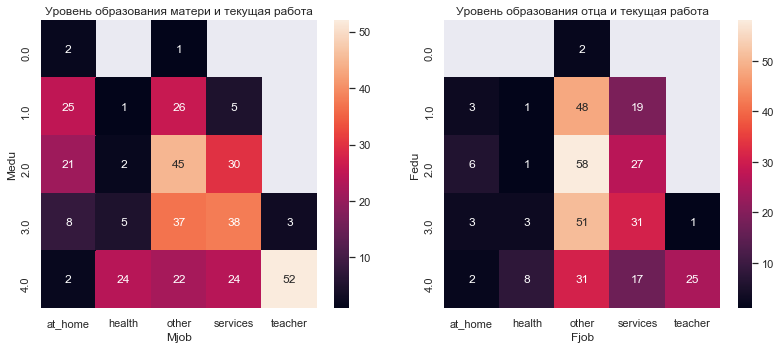

In [265]:
dataM= math.groupby(['Medu', 'Mjob'])['Mjob'].count().unstack()
dataF= math.groupby(['Fedu', 'Fjob'])['Fjob'].count().unstack()

fig, axes = plt.subplots(0, 2, figsize = (8, 4))

axes = fig.add_axes([0, 0, 0.6, 1])
axes = sns.heatmap(dataM, annot = True)
plt.title('Уровень образования матери и текущая работа')

axes = fig.add_axes([0.7, 0, 0.6, 1])
axes = sns.heatmap(dataF, annot = True)
plt.title('Уровень образования отца и текущая работа')

plt.show()

Диаграммы, показывают предсказуемую ситуацию, учителя и врачи - почти все в высшим образованием (минимум средне-специальное). Безработных женщин больше среди школьного образования (2 и 3). Можно использовать эти данные и заполнить пропущенные значения в уровне образования. Будем использовать самые популярные значения (моду) для мужчин и женщин отдельно. В конце, строки в которых останется Nan в обоих значениях **(MF)job** и **(MF)edu** заполним тоже самым популярным значением из всего датайрейма. 

In [266]:
#Заполняем пробелы в столбце образование    
math.Medu = math.Medu.fillna(math.Mjob.map(m_edu))
math.Fedu = math.Fedu.fillna(math.Fjob.map(f_edu))

#Заполняем пробелы в столбце работа
math.Mjob = math.Mjob.fillna(math.Medu.map(m_job))
math.Fjob = math.Fjob.fillna(math.Fedu.map(f_job))

#Заполняем 2 строки для отца где Nan в обоих столбцах
math.Fjob = math.Fjob.fillna(math.Fjob.mode()[0])
math.Fedu = math.Fedu.fillna(math.Fedu.mode()[0])

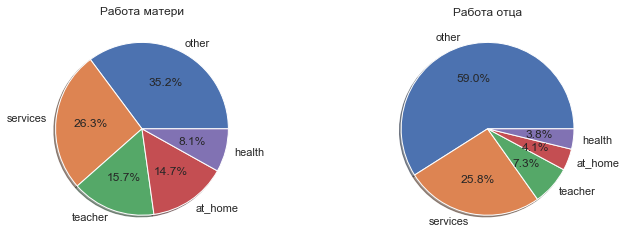

In [267]:
labels_mj = math.Mjob.value_counts().reset_index()['index'].to_list()
labels_fj = math.Fjob.value_counts().reset_index()['index'].to_list()

fig, axes = plt.subplots(0, 2, figsize = (6, 3))

axes = fig.add_axes([0, 0, 0.5, 1])
axes.pie(math.Mjob.value_counts(), labels=labels_mj, autopct='%1.1f%%', shadow=True)
plt.title('Работа матери')


axes = fig.add_axes([0.7, 0, 0.7, 1])
axes.pie(math.Fjob.value_counts(), labels=labels_fj, autopct='%1.1f%%', shadow=True)
plt.title('Работа отца')

plt.show()

### Опекун - guardian
* mother - мать
* father - отец
* other - другое

Посмотрим есть какие-либо различия в опекунах, где родители живут совместно или раздельно. 

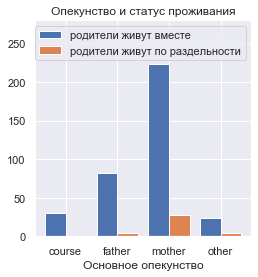

In [420]:
guard = pd.pivot_table(math, index = 'guardian', columns = 'Pstatus', values = 'sex', aggfunc = 'count').reset_index()

fig, axes = plt.subplots (0, 2, figsize = (6, 3) )

axes = fig.add_axes([0, 0, 0.5, 1])
axes.set_ylim(0, 280)
axes.bar(x = guard['guardian'], height = guard['T'],
               width = -0.4, align = 'edge', label = 'родители живут вместе')
axes.bar(x = guard['guardian'], height = guard['A'],
               width = 0.4, align = 'edge', label = 'родители живут по раздельности')

plt.title('Опекунство и статус проживания')
plt.xlabel('Основное опекунство')
axes.legend(loc=1)

plt.show()

In [269]:
math.guardian.value_counts()

mother    250
father     86
other      28
Name: guardian, dtype: int64

Основным опекуном во всех случаях явялется мать ("mother"), заполним пропущенные значения.

In [270]:
math.guardian = math.guardian.fillna(math.reason.mode()[0])

### Studytime - время на учебы в неделю помимо школы
* 1 - <2 часов
* 2 - 2-5 часов
* 3 - 5-10 часов
* 4 - >10 часов

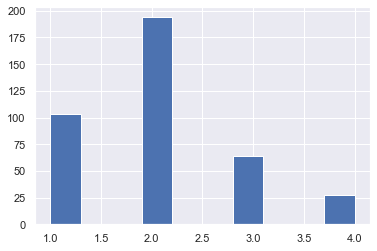

In [271]:
math.studytime.hist()
plt.show()

Посмотрим разницу по дополнительным часам для разных возрастных групп. У всех получается в среднем 2-5 часов дополнительных занятий. Заполним пропуски данным значением (2.0)

In [272]:
math.studytime = math.studytime.fillna(math.studytime.mode()[0])

### Failures - число внеучебных неудач
n, если 1<=n<3, иначе 0

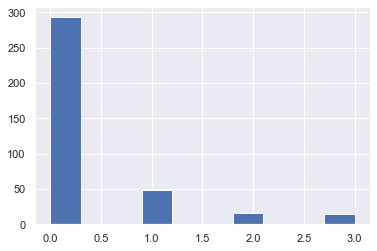

In [273]:
math.failures.hist()
plt.show()

Самое частое значение - 0. Заполним этим значением пропуски. 

In [274]:
math.failures = math.failures.fillna(math.failures.mode()[0])

### Schoolsup, Famsup, Paid
Рассмотрим дополнительную образовательную поддержку школы (**schoolsup**), семьи (**famsup**) и платные уроки (**paid**)

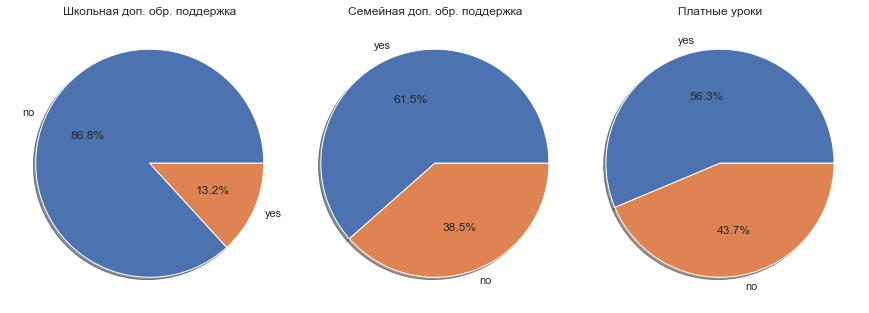

In [275]:
labels_ss = math.schoolsup.value_counts().reset_index()['index'].to_list()
labels_fs = math.famsup.value_counts().reset_index()['index'].to_list()
labels_paid = math.paid.value_counts().reset_index()['index'].to_list()

fig, axes = plt.subplots(0, 3, figsize = (12, 4))

axes = fig.add_axes([0, 0, 0.33, 1])
axes.pie(math.schoolsup.value_counts(), labels=labels_ss, autopct='%1.1f%%', shadow=True)
plt.title('Школьная доп. обр. поддержка')


axes = fig.add_axes([0.33, 0, 0.33, 1])
axes.pie(math.famsup.value_counts(), labels=labels_fs, autopct='%1.1f%%', shadow=True)
plt.title('Семейная доп. обр. поддержка')

axes = fig.add_axes([0.66, 0, 0.33, 1])
axes.pie(math.paid.value_counts(), labels=labels_fs, autopct='%1.1f%%', shadow=True)
plt.title('Платные уроки')

plt.show()

Заполним пропуски в **schoolsup** популярными значениями. Нужно заполнить около 40 пробелов в столбцах с семейнов поддержкой (**famsup**) и платными уроками (**paid**). Самое популярное значение, не сильно выраженно. Для того, чтобы их заполнить, рассмотрим их совместно.

ValueError: Unknown format code 'd' for object of type 'float'

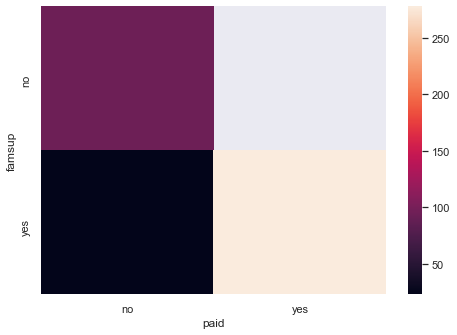

In [422]:
datapaid = math.groupby(['famsup', 'paid'])['paid'].count().unstack()

fig, axes = plt.subplots(0, 1, figsize = (6, 4))

axes = fig.add_axes([0, 0, 1, 1])
axes = sns.heatmap(datapaid, annot = True, fmt='d')
plt.title('Зависимость домашней поддержки и платных уроков')

plt.show()

Из карты видно, что если осуществляется семейная поддержка то почти в 80% случаев есть и платные уроки. Заполним пробелы в **paid** и **famsup** "yes" - "yes". Это будет примерно половина пропусков. Все остальные заполним - 'no'. 

In [277]:
#заполняем schoolsup
math.schoolsup = math.schoolsup.fillna(math.schoolsup.mode()[0])

In [281]:
#заполняем paid
math.loc[math.famsup == 'yes', 'paid'] = 'yes'
math.paid = math.paid.fillna(math.paid.mode()[0])

In [283]:
#заполняем famsup
math.loc[math.paid == 'yes', 'famsup'] = 'yes'
math.famsup = math.famsup.fillna(math.famsup.mode()[0])

### Activities, nursery, higher, internet, romantic
* **activities** - Дополнительный внеучебные занятия
* **nursery** - посещал детский сад
* **higher** - желание получить высшее образование
* **internet** - наличие интернета
* **romantic** - романтические отношения 

Все эти признаки бинарные Yes/No. Рассмотрим их подробнее и заполним пропуски

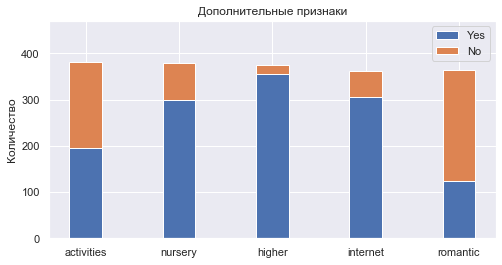

In [399]:
labels = ['activities', 'nursery', 'higher', 'internet', 'romantic']
counts = math[labels].apply(lambda x: x.value_counts()).T
ans_no = counts['no'].to_list()
ans_yes = counts['yes'].to_list()

fig, ax = plt.subplots(figsize=(8, 4))

width = 0.35

ax.bar(labels, ans_yes, width, label='Yes')
ax.bar(labels, ans_no, width, bottom=ans_yes,
       label='No')
ax.set_ylim(0, 470)
ax.set_ylabel('Количество')
ax.set_title('Дополнительные признаки')
ax.legend()

plt.show()

Из диаграммы видно: большинство учеников хочет получить высшее образование **higher**, дополнительные занятия **activities** примерно поровну. Большинство учеников посещало детской сад **nursery**. Эти столбцы заполним случайно из текущей пропорции. 

Наличие интернета **internet** рассмотрим дополнительно вместе с адресом проживания, наличие романтических отношений дополнительно рассмотрим с полом учеников (**sex**) и возрастом (**age**).  

#### Заполняем столбец romantic
Tаблица романтических отношений в зависимости от возраста и пола.

In [508]:
math.groupby(['age', 'sex', 'romantic']).size().unstack().T

age         15          16          17          18         19        20       \
sex          F     M     F     M     F     M     F     M    F    M    F    M   
romantic                                                                       
no        23.0  30.0  35.0  35.0  30.0  28.0  22.0  21.0  7.0  6.0  NaN  2.0   
yes       10.0   8.0  15.0  12.0  24.0  10.0  21.0  12.0  7.0  3.0  1.0  NaN   

age        21  
sex         M  
romantic       
no        1.0  
yes       1.0

отсутвующие значения в данных, в зависимости от возраста и пола.

In [509]:
math[math.romantic.isnull()].groupby(['age', 'sex']).size().unstack().T

age,15,16,17,18,19
sex,,,,,
F,5.0,4.0,4.0,NaN,NaN
M,6.0,3.0,2.0,6.0,1.0


Действительно есть зависимость и от возраста и от пола, но разница незначительна. Все значения могут уложиться в промежуток от 30...50% Но при этом пропущенных значений слишком мало(1 или 2) , чтобы это сыграло какую то роль при случайном заполнении. Поэтому заполним случайно, но будем учитывать только пол учеников (а возраст - нет).

In [525]:
# создадим переменные исходя из процента отношений для мальчиков и девочек
rom_m = math.query('sex == "M"').romantic.value_counts(normalize = True)['yes']
rom_f = math.query('sex == "F"').romantic.value_counts(normalize = True)['yes']

#создадим маску для сокращения записи M/F
maskM = (math.sex == "M") & (math.romantic.isnull())
maskF = (math.sex == "F") & (math.romantic.isnull())

#заполним случайно исходя из пола
math.loc[maskM, 'romantic'] = math[maskM].romantic.apply(lambda x: yesno_fill(rom_m))
math.loc[maskF, 'romantic'] = math[maskF].romantic.apply(lambda x: yesno_fill(rom_f))

#### Заполняем столбцы higher, activities, nursery

In [517]:
# создадим переменные 
int_h = math.higher.value_counts(normalize = True)['yes']
int_n = math.nursery.value_counts(normalize = True)['yes']
int_act = math.activities.value_counts(normalize = True)['yes']

#заполним
math.loc[math.higher.isnull(), 'higher'] = math[math.higher.isnull()].higher.apply(lambda x: yesno_fill(int_h))
math.loc[math.nursery.isnull(), 'nursery'] = math[math.nursery.isnull()].nursery.apply(lambda x: yesno_fill(int_n))
math.loc[math.activities.isnull(), 'activities'] = math[math.activities.isnull()]\
                                .activities.apply(lambda x: yesno_fill(int_act))

#### Заполняем столбец internet

In [518]:
# создадим переменные исходя из процента интернета для города и пригорода
int_R = math.query('address == "R"').internet.value_counts(normalize = True)['yes']
int_U = math.query('address == "U"').internet.value_counts(normalize = True)['yes']

#создадим маску для сокращения записи R/U
maskR = (math.address == "R") & (math.internet.isnull())
maskU = (math.address == "U") & (math.internet.isnull())

#заполним случайно исходя из статистики для R/U
math.loc[maskR, 'internet'] = math[maskR].internet.apply(lambda x: yesno_fill(int_R))
math.loc[maskU, 'internet'] = math[maskU].internet.apply(lambda x: yesno_fill(int_U))

In [527]:
math.describe(include = 'all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
school,395,2,GP,349,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sex,395,2,F,208,NaN,NaN,NaN,NaN,NaN,NaN,NaN
age,395,NaN,NaN,NaN,16.69,1.266,15,16,17,18,21
address,395,2,U,310,NaN,NaN,NaN,NaN,NaN,NaN,NaN
famsize,395,2,GT3,288,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Pstatus,395,2,T,359,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Medu,395,NaN,NaN,NaN,2.747,1.095,0,2,3,4,4
Fedu,395,NaN,NaN,NaN,2.532,1.074,0,2,3,3,4
Mjob,395,5,other,139,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Fjob,395,5,other,233,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# ЧЕРНОВИК!!!

## Анализ категориальных (оценочных) переменных
Medu, Fedu, traveltime, studytime, failures, famrel, freetime, goout, health

Для начала посмотрим распределение значений этих признаков.

Удалим пустые значения при вызове функции, чтобы не заполнять их None 

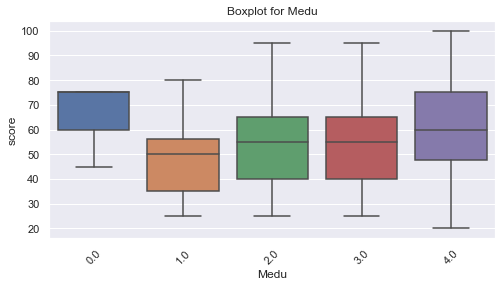

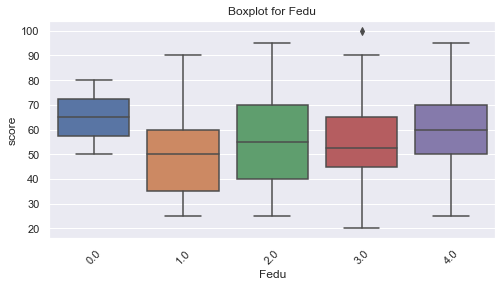

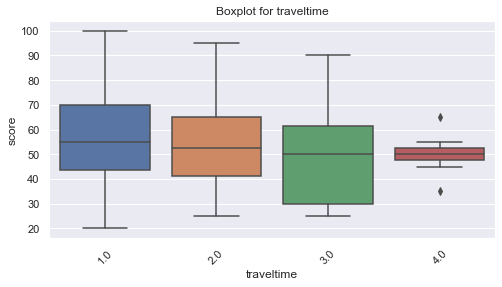

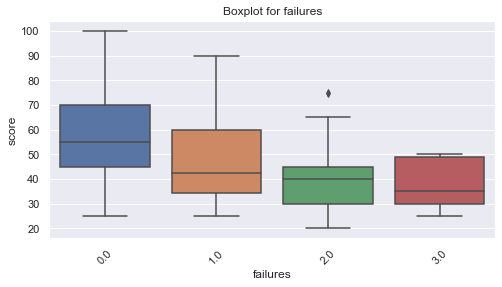

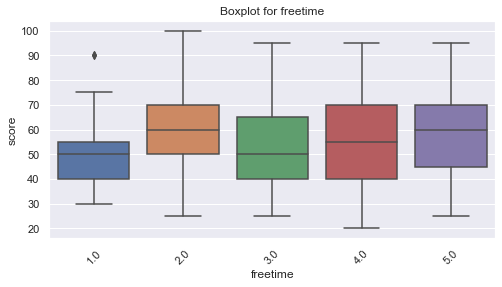

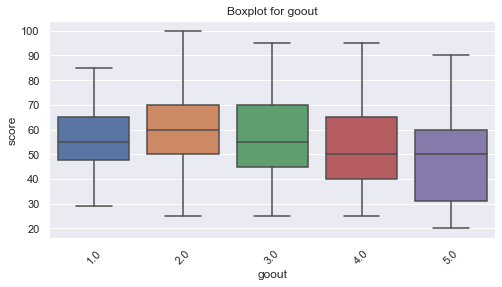

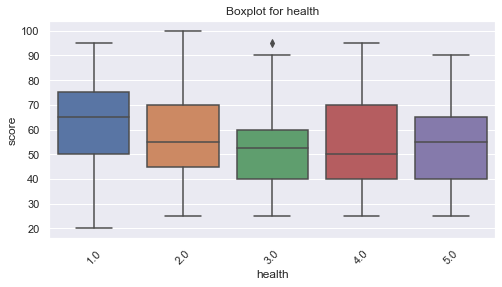

In [139]:
for i, col in enumerate(['Medu', 'Fedu', 'traveltime', 'failures',
            'freetime', 'goout', 'health']):
    get_boxplot2(col)


Проверим статистически значимые различия для колонок. 

In [ ]:
for i, col in enumerate(['Medu', 'Fedu', 'traveltime', 'failures',
            'freetime', 'goout', 'health']):
    get_stat_dif(col)

Найдены различия в колонках Medu (образование матери), failures (внеучебные неудачи), goout (общение с друзьями).
Если с колонками failures и goout вопросов не возникает, то вывод насчет Medu (и почему не попало Fedu) сделаем после исследования значений Mjob и Fjob.

## Анализ категориальные (номинативных) переменных
4 столбца: Mjob, Fjob, reason, guardian

In [ ]:
for i, col in enumerate(['Mjob', 'Fjob', 'reason', 'guardian']):
    get_boxplot2(col)

Значения guardian и reason почти не отличаются на боксплотах, проверим тестом на статистические различия. 

In [ ]:
for i, col in enumerate(['Mjob', 'Fjob', 'reason', 'guardian']):
    get_stat_dif(col)

Найдено статистическое различие только для работы матери (Mjob). Чтобы понять причину, посмотрим тепловые карты между образованием и работой отца и матери

In [ ]:
dataM= math.groupby(['Medu', 'Mjob'])['Mjob'].count().unstack()
dataF= math.groupby(['Fedu', 'Fjob'])['Fjob'].count().unstack()

fig, axes = plt.subplots(0, 2, figsize = (6, 3))

axes = fig.add_axes([0, 0, 0.6, 1])
axes = sns.heatmap(dataM, annot = True)
plt.title('Уровень образования матери и текущая работа')

axes = fig.add_axes([0.7, 0, 0.6, 1])
axes = sns.heatmap(dataF, annot = True)
plt.title('Уровень образования отца и текущая работа')

plt.show()

Из карт видно логическое объяснение - много женщин (матерей - Mjob) с высшим образованием (Medu = 4.0) работает учителями. Возможно по этой причине уровень образования Medu считается статистическим важным.
Проверим это, сделав тест для Medu, но убрав оттуда всех учителей (Mjob='teacher')

In [ ]:
# для проеверки создадим сокращенную копию датафрейма math
math_medu = math[['Mjob', 'Medu', 'score']].copy()
math_medu = math_medu[~(math_medu['Mjob'] == 'teacher')]
math_medu.Mjob.value_counts()

In [ ]:
cols = math_medu.loc[:, 'Medu'].value_counts().index[:5]
combinations_all = list(combinations(cols, 2))
for comb in combinations_all:
    if ttest_ind(math_medu.loc[math_medu.loc[:, 'Medu'] == comb[0], 'score'], 
                    math_medu.loc[math_medu.loc[:, 'Medu'] == comb[1], 'score']).pvalue \
        <= 0.05/len(combinations_all): # Учли поправку Бонферони
        print('Найдены статистически значимые различия для колонки', 'Medu')
        break

Наша теория не подтвердилась оба признака для матери Mjob и Medu будем считать статистически значимыми. 

## Анализ категориальных бинарных признаков.
13 столбцов: school, sex, address, famsize, Pstatus, schoolsup, famsup, paid, activities, nursery, higher, internet, romantic

In [ ]:
for i, col in enumerate(['school', 'sex', 'address', 'famsize', 
                         'Pstatus', 'schoolsup', 'famsup', 
                         'paid', 'activities', 'nursery', 
                         'higher', 'internet', 'romantic']):
    get_boxplot2(col)

По данным боксплотов такие признаки как школа (school), размер семьи(famsize), статус проживания родителей (Pstatus), 
поддержка семьи (famsup), платные уроки (paid), дополнительные внеучебные занятия (activities), детский сад (nursery), романтические отношения (romantic) - не влияют на итоговую оценку. 

In [ ]:
for i, col in enumerate(['school', 'sex', 'address', 'famsize', 
                         'Pstatus', 'schoolsup', 'famsup', 
                         'paid', 'activities', 'nursery', 
                         'higher', 'internet', 'romantic']):
    get_stat_dif(col)

Тест подтверждает данную теорию, для оценки важны: пол учеников (девочки лучше учатся чем мальчики), место проживания (у городских учеников оценка выше), поддержка школы и желание получить высшее образование. 

In [70]:
math_EDA = math[['sex', 'age', 'address', 'Medu', 'Mjob', 'failures', 
                 'schoolsup', 'higher', 'goout', 'score']]

In [71]:
math_EDA.sample(5)

,sex,age,address,Medu,Mjob,failures,schoolsup,higher,goout,score
273,M,17,R,1.0,at_home,0.0,no,yes,2.0,70.0
352,M,18,U,1.0,at_home,1.0,no,no,3.0,40.0
51,F,15,U,4.0,health,0.0,no,yes,3.0,65.0
65,F,16,U,4.0,teacher,0.0,no,yes,3.0,75.0
236,M,17,U,2.0,other,0.0,no,yes,2.0,65.0


## Выводы

* В данных было мало пустых значений (<5%), больше всего пробелов в столбцах (Pstatus, paid , etc), которые были удалены.
* столбец "studytime, granular" полностью копировал столбец "studytime", но с коэффициентом -2.5 и тоэе был удален.
* Положительная корреляция есть только относительно возраста учеников. С возрастом дети учатся хуже.
* Девочки учатся лучше чем мальчики
* Жители города учатся лучше, чем ученики из пригорода
* Если много проводить время с друзьями, то оценки ухудшаются
* Важно желание самого ученика. Желаение получить высшее образование улучшает итоговую оцунку.
* Поддержка школы (дополнительные занятия) также улучшают оценку. 
* В семье наиболее важным оказались высшее образование и работа матери ученика. 
* наличие внеучебных неудач плохо отражается на оценках. 

* Итоговые данные для оценки учеников: sex, age, address, Medu, Mjob, failures, schoolsup, higher, goout, score

## 2. Оценка номинативных переменных

In [ ]:
for col in ['school', 'sex', 'address', 'reason']:
    get_boxplot(col)

In [ ]:
for col in ['school', 'sex', 'address', 'reason']:
    get_stat_dif(col)

In [ ]:
for col in ['Medu', 'Fedu', 'Mjob', 'Fjob']:
    get_boxplot(col)

In [ ]:
for col in ['Medu', 'Fedu', 'Mjob', 'Fjob']:
    get_stat_dif(col)

In [ ]:
for col in ['guardian', 'studytime', 'traveltime', 'failures']:
    get_boxplot(col)

In [ ]:
for col in ['guardian', 'studytime', 'traveltime', 'failures']:
    get_stat_dif(col)

In [ ]:
for col in ['schoolsup', 'famsup', 'paid']:
    get_boxplot(col)

In [ ]:
for col in ['schoolsup', 'famsup', 'paid']:
    get_stat_dif(col)

In [ ]:
for col in ['activities', 'nursery', 'internet', 'higher', 'romantic']:
    get_boxplot(col)

In [ ]:
for col in ['activities', 'nursery', 'internet', 'higher', 'romantic']:
    get_stat_dif(col)